# Nubes de puntos

En este cuaderno se muestra como cargar, manipular y exportar nubes de puntos en formato LAS y también en formato CSV. Para ello se introducen las librería laspy y pandas respectivamente. No se desarrollan en detalle técnicas de tratamiento de nubes de puntos. Simplemente se muestran las mecánicas básicas para trabajar con este tipo de archivos desde python.

## Importar librerías

Las principales novedades de este cuaderno son las ibrería laspy y pandas, que permiten trabajar cómodamente con archivos codificados según el formato LAS o el formato CSV desde python. También se introduce la librería recordclass, que permite generar estructuras de datos mutables similares a clases. Esta última será utilizada para asistir al desarrollo de un sencillo algoritmo de ejemplo para mostrar como aplicar un procesamiento a la nube de puntos desde python.

In [1]:
# Importar librerías
import laspy
import numpy as np
import pandas as pd
from recordclass import recordclass
from math import floor, ceil
from matplotlib import pyplot as plt
import time

In /home/uadmin/.local/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/uadmin/.local/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/uadmin/.local/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/uadmin/.local/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/uadmin/.local/lib/python3.7/site-packages/matplotlib/mpl-data/s

## Importar nube de puntos

En primer lugar, se carga la nube de puntos desde el archivo LAS. Para este cuaderno se eligen las coordenadas espaciales, la intensidad y el color. El resto de campos del estandar LAS también están disponibles.

In [2]:
# Leer nube de puntos en formato LAS
lasfin = laspy.file.File(
    "/smalldata/lidar_data/sixtema/LiDAR_castros/San_Amaro-Ou/PNOA_2016_GAL_E_578-4692_ORT-CLA-COL_edited.las",
    mode='r'
)
X = np.vstack([
    lasfin.X*lasfin.header.scale[0] + lasfin.header.offset[0],
    lasfin.Y*lasfin.header.scale[1] + lasfin.header.offset[1],
    lasfin.Z*lasfin.header.scale[2] + lasfin.header.offset[2],
    lasfin.intensity,
    lasfin.red,
    lasfin.green,
    lasfin.blue
]).transpose()
Rab = [np.min(X[:,4]), np.max(X[:,4])]
Gab = [np.min(X[:,5]), np.max(X[:,5])]
Bab = [np.min(X[:,6]), np.max(X[:,6])]
print(X)
print('X dimensiones ', X.shape)


[[5.78328990e+05 4.69000822e+06 4.03840000e+02 ... 2.61120000e+04
  2.61120000e+04 2.50880000e+04]
 [5.78315030e+05 4.69003354e+06 4.06600000e+02 ... 2.22720000e+04
  2.07360000e+04 1.94560000e+04]
 [5.78316660e+05 4.69003453e+06 4.06460000e+02 ... 2.07360000e+04
  2.20160000e+04 2.17600000e+04]
 ...
 [5.79990910e+05 4.69199955e+06 3.33590000e+02 ... 4.50560000e+04
  4.68480000e+04 4.04480000e+04]
 [5.79993180e+05 4.69199988e+06 3.33470000e+02 ... 1.92000000e+04
  2.32960000e+04 1.89440000e+04]
 [5.79998720e+05 4.69199994e+06 3.32450000e+02 ... 1.43360000e+04
  2.20160000e+04 1.81760000e+04]]
X dimensiones  (5577233, 7)


## Información espacial básica

Una vez cargada la nube de puntos, se extrae una información básica sobre el espacio de la misma. Concretamente $O$ que será el punto central del prisma rectangular alineado con los ejes canónicos que contiene la nube puntos. Pero también $P$, que es la matriz de coordenadas de la nube de puntos traspuesta de tal manera que tenga por centro el origen. Es decir, si se calculase $O$ para $P$ en lugar de para la nube de puntos original, este sería $(0, 0, 0)$.

De ahora en adelante, para tomar decisiones espaciales sobre la nube de puntos, se considerarán las coordenadas en $P$ en lugar de las coordenadas originales. Al ser $P$ una traslación de la nube de puntos, se trata de un movimiento rígido y, por tanto, es una isometría. Esto quiere decir que se conservan la norma y el producto escalar, por tanto las medidas de distancia también. Así, los razonamientos espaciales asociados a $P$ son análogos a la nube de puntos original. Sin embargo, $P$ es más conveniente, al encontrarse centrada en el origen.

Sería posible a su vez normalizar $P$, lo que puede reducir problemas de precisión decimal en los cálculos. Sin embargo, en este cuaderno no se hará, ya que únicamente pretende servir como introducción a la manipulación de nubes de puntos. Téngase en cuenta que normalizar $P$ implicaría escalar, por lo que las distancias proporcionales se mantendrían pero las absolutas variarían en el factor de escala. Por tanto, en caso de fijar distancias como parámetros (por ejemplo, una ventana convolucional en distancia euclidea), deberían escalarse oportunamente considerando la norma.

In [3]:
# Extraer transformación de centro en X, Y, Z
def transf(P, xIdx=0, yIdx=1, zIdx=2):
    X = P[:, xIdx]
    Y = P[:, yIdx]
    Z = P[:, zIdx]
    xmin = np.min(X)
    ymin = np.min(Y)
    zmin = np.min(Z)
    xmax = np.max(X)
    ymax = np.max(Y)
    zmax = np.max(Z)
    O = np.array([(xmin+xmax)/2.0, (ymin+ymax)/2.0, (zmin+zmax)/2.0])
    return np.array([X-O[0], Y-O[1], Z-O[2]]).transpose(), O
    

P, O = transf(X)
print('P dimensiones ', P.shape)

P dimensiones  (5577233, 3)


## Descomposición en bloques con interpolación basada en promedio

A continuación se define un método de descomposición en bloques. La nube de puntos es descompuesta como máximo en tantos bloques como se deduzcan del vector $n=(n_x, n_y, n_z)$. Donde cada componente indica el número de particiones que se harán a lo largo del eje asociado. Todo aquel bloque que no contenga puntos, será descartado. Por tanto, cabe esperar que se obtenga un número de bloques menor que el máximo posible, pues muchas regiones no contendrán puntos.

Una vez descompuesta la nube de puntos en bloques o celdas, puede aplicarse una función para interpolar los valores que debe tomar cada bloque o celda respecto de los puntos asociados de la nube original. En este caso se utilizará una simple interpolación promedio para todos los valores, tanto los espaciales $(x,y, z)$ como los de canal $(R, G, B, I)$. De esta manera, se obtiene una versión reducida de la nube de puntos original que contiene menos puntos. Puede entenderse también como un filtro de suavizado, aunque posiblemente sería más efectivo utilizar una interpolación gausiana en lugar de un simple promedio, de manera análoga a como se vio en el tratamiento de imágenes.

Finalmente, se normaliza el color al intervalo $[0, 1]$ y se exporta la nube de puntos resultante. La comparativa entre la nube de puntos original y la procesada (mitad de puntos) quedaría tal que:

**Original**
![Nube de puntos original](../img/SanAmaro_base.png)

**Reducción promedio**
![Nube de puntos procesada](../img/SanAmaro_mean.png)



In [4]:
# Definición de celda
Cell = recordclass('Cell', ['ijk', 'indices', 'vals'])

# Función de interpolación
def interpf_mean(X, indices, xIdx=0, yIdx=1, zIdx=2):
    return np.mean(X[indices], axis=0)
    
# Descomposición en bloques  
def decomp(X, P=None, n=[1024, 1024, 128], xIdx=0, yIdx=1, zIdx=2, interpf=interpf_mean, postf=None):
    # Cálculos previos de la descomposición espacial
    if P is None:
        P = transf(X)
    xmin = np.min(P[:, 0])
    xmax = np.max(P[:, 0])
    xdelta = xmax-xmin
    dx = xdelta/n[0]
    ymin = np.min(P[:, 1])
    ymax = np.max(P[:, 1])
    ydelta = ymax-ymin
    dy = ydelta/n[1]
    zmin = np.min(P[:, 2])
    zmax = np.max(P[:, 2])
    zdelta = zmax-zmin
    dz = zdelta/n[2]
    nz = n[2]
    nynz = n[1]*n[2]
    
    # Construir red de bloques
    start = time.perf_counter()
    G = {}
    xend = n[0]-1
    yend = n[1]-1
    zend = n[2]-1
    for idx, p in enumerate(P):
        i = min(floor((p[0]-xmin)/dx), xend)
        j = min(floor((p[1]-ymin)/dy), yend)
        k = min(floor((p[2]-zmin)/dz), zend)
        Gidx = i*nynz + j*nz + k
        if G.get(Gidx, None) is None:
            G[Gidx] = Cell((i, j, k), [idx], None)
        else:
            G[Gidx].indices.append(idx)
    end = time.perf_counter()
    print('Red construida ({t} s)!'.format(t=end-start))
    
    # Interpolar valores
    Y = []
    start = time.perf_counter()
    for cell in G.values():
        i, j, k = cell.ijk
        indices = []
        for x in [i-1, i, i+1]:
            if x >= n[0]:
                continue
            for y in [j-1, j, j+1]:
                if y >= n[1]:
                    continue
                for z in [k-1, k, k+1]:
                    if z >= n[2]:
                        continue
                    Gidx = x*nynz + y*nz + z
                    if G.get(Gidx, None) is not None:
                        indices = indices + G[Gidx].indices
        cell.vals = interpf(X, indices, xIdx=xIdx, yIdx=yIdx, zIdx=zIdx)    
    end = time.perf_counter()
    print('Red interpolada ({t} s)!'.format(t=end-start))
    
    # Postprocesado
    if postf is not None:
        start = time.perf_counter()
        postf(G, nynz, nz)
        end = time.perf_counter()
        print('Postprocesado ({t} s)!'.format(t=end-start))
        
    return np.array([g.vals for g in G.values()])
    
    
Y = decomp(X, P=P)
print('Y dimensiones ', Y.shape)

Red construida (20.426989114999742 s)!
Red interpolada (122.50792628799991 s)!
Y dimensiones  (2479245, 7)


In [5]:
# Normalizar los canales de color a [0, 1]
Y[:, 4] = (Y[:, 4] - Rab[0])/(Rab[1]-Rab[0])
Y[:, 5] = (Y[:, 5] - Gab[0])/(Gab[1]-Gab[0])
Y[:, 6] = (Y[:, 6] - Bab[0])/(Bab[1]-Bab[0])

# Exportar la nube de puntos
np.savetxt("/home/uadmin/tmp/sixtema/n004_mean.xyz", Y, delimiter=' ')

## Descomposición en bloques con interpolación y post-procesado por varianza

Aquí se combinará la descomposición en bloques, en esta ocasión interpolando la varianza $\sigma^2$ para distintas vecindades, con un post-procesado. El post-procesado tiene dos filtros. En primer lugar, únicamente permite que estén activos aquellos puntos que se encuentren en un intervalo definido respecto de la varianza de su vecindad $[\sigma^2_{a}, \sigma^2_{b}]$. En segundo lugar, construye el histograma de frecuencias relativas para filtrar, según su distribución, aquellas vecindades que sean similares a castros. Para ello, se utiliza una estrategía de decisión basada en votación (bagging), con unas reglas lógicas establecidas respecto de las distintas discretizaciones de la distribución:


**1.** Si $b_0 \geq 0.8$, entonces votar positivo $(p+1)$.

**2.** Si $b_1 \geq 0.2$, entonces votar negativo $(n+1)$.

**3.** Si $b_2 \geq 0.1$, entonces votar negativo $(n+1)$.

**4.** Si $b_3 \geq 0.05$, entonces votar negativo $(n+1)$.

En función del resultado:

**1.** Si $p=1 \land n>1$, entonces eliminar.

**2.** Si $p<1 \land n>0$, entonces eliminar.

**3.** Sino, preservar. Es decir, si antes del post-procesado estaba activado, seguirá activado.

El análisis de histográmas no permite segmentar los píxeles del castro de manera separada de un montón de ruido distribuido sobre el resto de la imagen. Sin embargo, permite hacer una reducción tal que se eliminen proporcionalmente más puntos de ruido que de castro, por lo que luego será posible aplicar un filtro convolucional de limpieza en 2D. Este filtro que se comentará más adelante, no funcionaría correctamente con un simple filtrado $\sigma^2 \in [\sigma^2_{a}, \sigma^2_{b}]$ sino que requiere una entrada filtrada por histograma o no consigue limpiar el ruido correctamente. Aquí se muestra la salida con filtro de post-procesado por histograma de varianza en $z$, antes de aplicarle el filtro de limpieza posterior:

**Interpolación y post-procesado por varianza**
![Interpolación y post-procesado por varianza](../img/SanAmaro_zvariance.png)

In [6]:
# Función de interpolación mean + zvar
def interpf_zvar(X, indices, xIdx=0, yIdx=1, zIdx=2):
    Q = X[indices]
    mean = np.mean(Q, axis=0)
    zvar = np.var(Q[:, zIdx])
    return np.concatenate([mean, [zvar], [0]])
    
# Función de postprocesado para zvar
def postf_zvar(G, nynz, nz, depth=5, zvar_min=0.3, zvar_max=1.5, use_histogram=True):
    shift = [i for i in range(1, depth)] + [-i for i in range(1, depth)] + [0]
    actives = []
    for cell in G.values():
        # Ignorar celdas no activadas (zvar insuficiente o excesivo)
        zvar = cell.vals[7]
        if zvar < zvar_min or zvar > zvar_max:
            continue
        # Obtener las zvar de los vecinos en xy (para todo z)
        i, j, k = cell.ijk
        zvars = []
        for a in shift:
            x = (i+a)*nynz
            for b in shift:
                y = (j+b)*nz
                for c in shift:
                    z = k+c
                    Gidx = x+y+z
                    neigh = G.get(Gidx, None)
                    if neigh is not None:
                        zvars.append(neigh.vals[7])
        if use_histogram:
            # Preparar histograma
            zvars = np.clip(zvars, 0, 6)
            bins = [0 for i in range(4)]
            for zvar in zvars:
                if zvar < 1.5:
                    bins[0] += 1
                elif zvar < 3:
                    bins[1] += 1
                elif zvar < 4.5:
                    bins[2] += 1
                else:
                    bins[3] += 1
            bins = np.array(bins) / np.sum(bins)
            # Votación
            positives, negatives = (0, 0)
            if bins[0] >= 0.8:
                positives += 1
            if bins[1] >= 0.2:
                negatives += 1
            if bins[2] >= 0.1:
                negatives += 1
            if bins[3] >= 0.05:
                negatives += 1
            remove = False
            if positives==1 and negatives >= 2:
                remove = True
            if positives < 1 and negatives >= 1:
                remove = True    
        else:  # En caso de no usar histogramam considerar sólo el filtro [zvar_min, zvar_max]
            remove = False
        # Filtrado
        if not remove:
            cell.vals[8] = 1
            actives.append(cell)    
    
              
Y = decomp(X, P=P, interpf=interpf_zvar, n=[1024, 1024, 1], postf=postf_zvar)
print('Y dimensiones ', Y.shape)

Red construida (17.052135792000627 s)!
Red interpolada (110.658416407 s)!
Postprocesado (61.000140242999805 s)!
Y dimensiones  (1044590, 9)


In [7]:
# Normalizar los canales de color a [0, 1]
Y[:, 4] = (Y[:, 4] - Rab[0])/(Rab[1]-Rab[0])
Y[:, 5] = (Y[:, 5] - Gab[0])/(Gab[1]-Gab[0])
Y[:, 6] = (Y[:, 6] - Bab[0])/(Bab[1]-Bab[0])

# Exportar la nube de puntos
np.savetxt("/home/uadmin/tmp/sixtema/n004_zvar.xyz", Y, delimiter=' ')

## Limpieza

Como se mencionó anteriormente, se puede aplicar un criterio de limpieza basado en convoluciones para desactivar aquellos puntos detectados como castro que no estén en zonas de suficiente densidad. La diferencia entre la limpieza que recibe una entrada post-procesada en función de su distribución *(derecha)* y una que no *(izquierda)*, es evidente.



**Limpieza sin y con post-procesado por distribución en histograma**
![Interpolación y post-procesado por varianza](../img/SanAmaro_cleaning_histvsnohist.png)

El método de limpieza es muy sencillo. Se basa en ir deslizando una ventana en 2D definida por una magnitud para $x$ y una magnitud para $y$, tal que $\vec{w}=[w_x, w_y]$. El paso de este deslizamiento viene definido en 2D también por un un vector $\vec{s}=[s_x, s_y]$. Todo aquel punto activado que no esté en al menos una ventana con una densidad que tenga una población que llegue a un mínimo $th$, será desactivado. Como con el histograma se reduce en una proporción mayor la densidad de puntos que no corresponden con el castro de la imagen respecto de aquellos que sí, la limpieza es mucho más efectiva.

Por último, nótese que se aplica el filtro dos veces. Primero con una ventana de mayor tamaño. Después con una ventana y un paso cuyas componentes están reducidas a la mitad, mientras que el criterio de vecindad mínima se reduce algo más de la mitad.

Primera limpieza:
Malla construida en 0.00045791200045641745 s
Malla poblada en 0.9787597009999445 s
Activos contados en 0.9845455839995338 s
Limpieza preparada en 0.8112151129998892 s
27493 puntos limpiados en 0.6367335809991346 s

Segunda limpieza:
Malla construida en 0.0009356380005556275 s
Malla poblada en 0.36167740099972434 s
Activos contados en 0.48359725200043613 s
Limpieza preparada en 0.4666515939998135 s
705 puntos limpiados en 0.6475487729994711 s


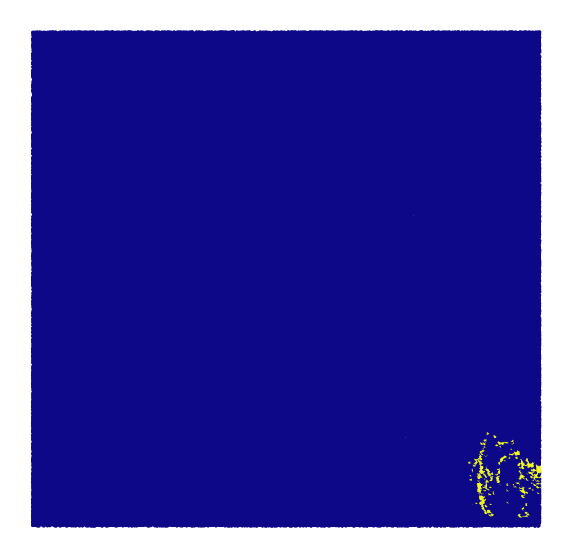

In [8]:
# Función para eliminar ruido
def noise_cleaning(X, P, min_neighs=4000, cw=[400, 400], cs=[40, 40]):
    # Preparar malla
    xmin = np.min(P[:, 0])
    xmax = np.max(P[:, 0])
    xdelta = xmax-xmin
    m = ceil(xdelta/cs[0])
    mth = m-1
    mdelta = m/xdelta
    dx = floor(cw[0]/cs[0])
    rx = max(dx-1, 0)
    xnotdiv = (cw[0] % cs[0])
    ymin = np.min(P[:, 1])
    ymax = np.max(P[:, 1])
    ydelta = ymax-ymin
    n = ceil(ydelta/cs[1])
    nth = n-1
    ndelta = n/ydelta
    dy = floor(cw[1]/cs[1])
    ry = max(dy-1, 0)
    ynotdiv = (cw[1] % cs[1])

    # Construir la malla
    start = time.perf_counter()
    G = [[[] for j in range(n)] for i in range(m)]
    end = time.perf_counter()
    print('Malla construida en {t} s'.format(t=end-start))
    
    # Poblar la malla
    start = time.perf_counter()
    for idx, p in enumerate(P):
        if X[idx, 8] < 1.0:  # Ignorar puntos no activados
            continue
        qx, qy = (p[0]-xmin, p[1]-ymin)
        x = min(floor(qx*mdelta), mth)
        y = min(floor(qy*ndelta), nth)
        G[x][y].append(idx)  # Añadir a vecindad principal
        for tx in range(dx):
            x2 = x-1-tx  # Calcular ventanas hacia atrás en rango para x
            if x2 < 0:  # Si no es posible ir más hacia atrás, finalizar el bucle
                break
            if xnotdiv: # Comprobar que proceda la ventana (necesario cuando ¬ cs[0]|cw[0])                
                x2th = x2*cs[0]+cw[0]
                if qx > x2th:
                    break
            for ty in range(dy):
                y2 = y-1-ty  # Calcular ventanas hacia atrás en rango para y
                if y2 < 0:  # Si no es posible ir más hacia atrás, finalizar el bucle
                    break
                if ynotdiv: # Comprobar que proceda la ventana (necesario cuando ¬ cs[1]|cw[1])                
                    y2th = y2*cs[1]+cw[1]
                    if qy > y2th:  
                        break
                G[x2][y2].append(idx) # Añadir a vecindades secundarias 
        end = time.perf_counter()
    print('Malla poblada en {t} s'.format(t=end-start))
    
    
    # Contar activados 
    for G_row in G:
        for k, g in enumerate(G_row):
            G_row[k] = len(g)
    end = time.perf_counter()
    print('Activos contados en {t} s'.format(t=end-start))
    
            
    # Preparar limpieza
    start = time.perf_counter()
    activate = np.zeros(X.shape[0])
    for idx, p in enumerate(P):
        if X[idx, 8] < 1.0:  # Ignorar puntos no activados
            continue
        x = min(floor((p[0]-xmin)*mdelta), mth)
        y = min(floor((p[1]-ymin)*ndelta), nth)
        if G[x][y] >= min_neighs:  # Comprobar vecindad principal
            activate[idx] = 1.0
        for tx in range(dx):
            x2 = x-1-tx  # Calcular ventanas hacia atrás en rango para x
            if x2 < 0:  # Si no es posible ir más hacia atrás, finalizar el bucle
                break
            if xnotdiv: # Comprobar que proceda la ventana (necesario cuando ¬ cs[0]|cw[0])                
                x2th = x2*cs[0]+cw[0]
                if qx > x2th:
                    break
            for ty in range(dy):
                y2 = y-1-ty  # Calcular ventanas hacia atrás en rango para y
                if y2 < 0:  # Si no es posible ir más hacia atrás, finalizar el bucle
                    break
                if ynotdiv: # Comprobar que proceda la ventana (necesario cuando ¬ cs[1]|cw[1])                
                    y2th = y2*cs[1]+cw[1]
                    if qy > y2th:  
                        break
                if G[x2][y2] >= min_neighs: # Comprobar vecindades secundarias
                    activate[idx] = 1.0
    end = time.perf_counter()
    print('Limpieza preparada en {t} s'.format(t=end-start))
                    
    # Limpiar todo punto que no llegue al mínimo de vecinos necesarios en al menos 1 ventana
    start = time.perf_counter()
    clean_count = 0
    for idx, p in enumerate(P):
        if activate[idx] < 1.0 and X[idx, 8] > 0.0:
            X[idx, 8] = 0.0
            clean_count += 1
    end = time.perf_counter()
    print('{n} puntos limpiados en {t} s'.format(n=clean_count, t=end-start))
                    
    # Devolver nube limpiada
    return X
    

# Aplicar filtros de limpieza
Q, O2 = transf(Y)
print('Primera limpieza:')
Z = noise_cleaning(np.copy(Y), Q, min_neighs=4000, cw=[400, 400], cs=[40, 40])
print('\nSegunda limpieza:')
Z = noise_cleaning(Z, Q, min_neighs=1600, cw=[200, 200], cs=[20, 20])

# Mostrar salida
plt.figure(figsize=(10, 10))
plt.scatter(Z[::5, 0], Z[::5, 1], c=Z[::5, 8], s=5, cmap='plasma')
plt.axis(False)
plt.show()

In [9]:
# Exportar la nube de puntos limpiada
np.savetxt("/home/uadmin/tmp/sixtema/n004_zvar_clean.xyz", Z, delimiter=' ')

## ¿Cómo se llega al post-procesado por histogramas?

El procesamiento anterior se basa en un filtro de histogramas sobre el cual se establecen una serie de reglas. Pero estas reglas no son establecidas de manera arbitraria, sino que responden a un análisis de distribución para distintas muestras de distintas regiones de la imagen. Se puede observar que existe una clara diferencia entre la zona mayoritaria de elevada varianza, el bosque, y las regiones más evidentes del castro.

Concretamente se estudian 5 muestras de castro distintas y 4 muestras de bosque distintas. Estas muestras han sido recortadas manualmente de la imagen. En todas ellas puede observarse que los votos provienen de distintas observaciones que son ciertas para los castros (casos a preservar) y otras que son ciertas para los bosques (casos a desactivar).

Ocurre que, además de las regiones típicas de bosque, hay otras zonas donde puede haber ruido. Estas regiones son diferentes y no comparten todas el mismo patrón. Por eso, el filtro de histograma sigue dando lugar a una salida con ruido. Pero al reducirse ese ruido en función de una regla que separa puntos de castro de puntos que no son de castro, se induce a un recorte mayor de puntos de ruido que de puntos de castro.

Por último, el considerar los histogramas en función de distribución por frecuencias relativas, suele ser preferible a considerar frecuencias absolutas. Esto se debe a que, en caso de aumentar la frecuencia de muestreo del sensor, las frecuencias absolutas cambiarán significativamente al haber más puntos, mientras que las relativas deberían mantenerse considerablemente uniformes a partir de un mínimo. Por supuesto caben otros factores, como el tipo de deflexión del láser o el tipo de soporte en el que encaje el sensor, su distancia respecto del suelo y otras cuestiones que pueden influir sensiblemente también en las distribuciones relativas. 

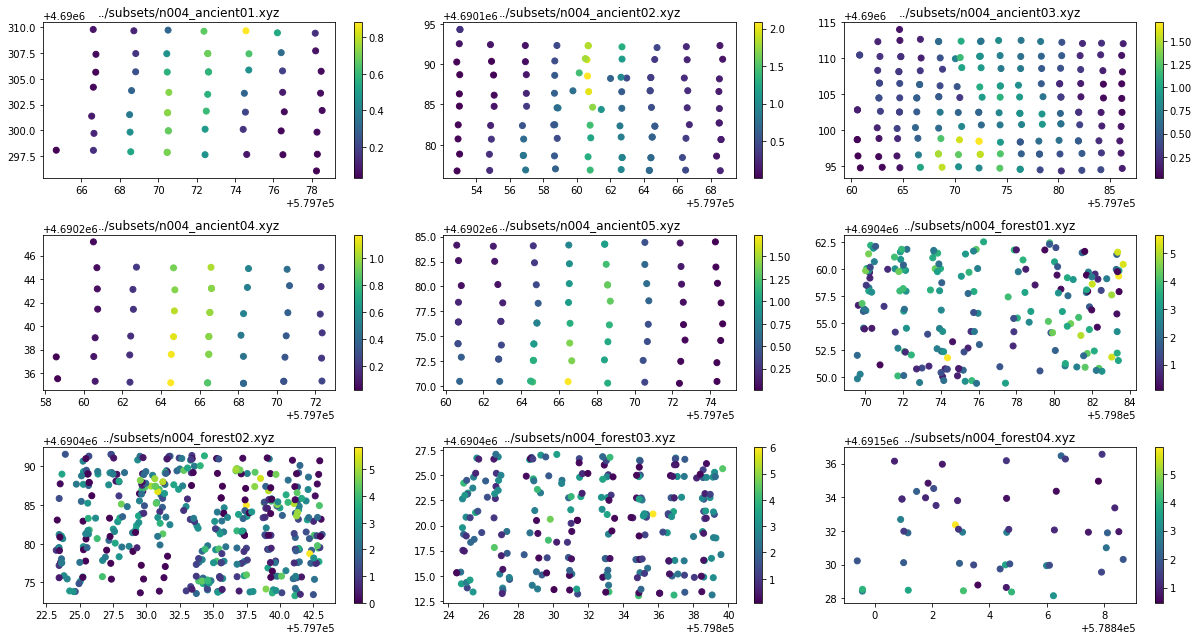

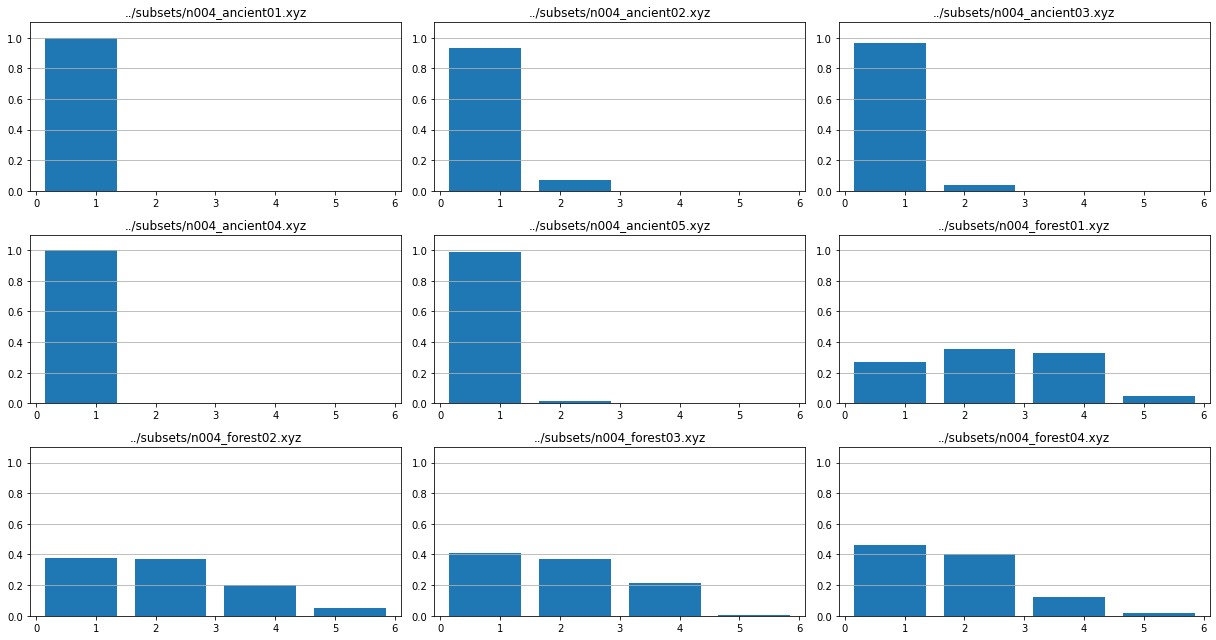

In [10]:
# Cargar datos
subset_paths = [
    '../subsets/n004_ancient01.xyz',
    '../subsets/n004_ancient02.xyz',
    '../subsets/n004_ancient03.xyz',
    '../subsets/n004_ancient04.xyz',
    '../subsets/n004_ancient05.xyz',
    '../subsets/n004_forest01.xyz',
    '../subsets/n004_forest02.xyz',
    '../subsets/n004_forest03.xyz',
    '../subsets/n004_forest04.xyz'
]
subsets = [
    pd.read_csv(path, delimiter=' ', header=None).to_numpy()
    for path in subset_paths
]

# Preparar bins
bins = [0, 1.5, 3, 4.5, 6]
vmin, vmax = (np.min(bins), np.max(bins))
for subset in subsets:
    subset[:, 7] = np.clip(subset[:, 7], vmin, vmax)
    
# Puntos coloreados por varianza
plt.figure(figsize=(17, 9))
for i, subset in enumerate(subsets):
    plt.subplot(3, 3, i+1)
    plt.scatter(subset[:, 0], subset[:, 1], c=subset[:,7])
    plt.colorbar()
    plt.title(subset_paths[i])
plt.tight_layout()
plt.show()
    

# Histogramas
plt.figure(figsize=(17, 9))
for i, subset in enumerate(subsets):
    plt.subplot(3, 3, i+1)
    H = subset[:, 7]
    plt.hist(H, bins=bins, weights=np.zeros_like(H) + 1.0 / H.shape[0], rwidth=0.8)
    plt.title(subset_paths[i])
    plt.axis([-0.1, 6.1, 0, 1.1])
    plt.grid(True, axis='y')
plt.tight_layout()
plt.show()
